# 1D nonlinear Schrodinger soliton collisions

Consider the Hamiltonian for a nonlinear, nonrelativistic, 1-dimensional soliton:

$$
\hat{H} = -\frac{1}{2m} \frac{d^2}{dx^2} + \alpha \left( |\psi|^2 - \bar{\psi}^2 \right)^2
$$

From our previous study on stationary solitons of this form, we know that we can recast the Schrodinger equation in a simpler, non-dimensional form

$$
-\frac{1}{2} \frac{d^2\chi}{d\xi^2} + \beta^2 \left[\left(|\chi|^2 - 1\right)^2 - 1\right] \chi = \mathcal{E} \chi \\
\text{where} \quad
\beta = \sqrt{\alpha m} \bar{\psi}^2 R
= R/R_0
= \frac{\widetilde{N}^2 + 1}{3^{1/4}\widetilde{N}}, \quad
\mathcal{E} = m R^2 E, \quad
R = \frac{4\sqrt{3} N^2 \alpha m + 3\pi}{6\sqrt{\pi} N \alpha \bar{\psi}^2 m}
= \frac{R_0}{3^{1/4}} \frac{\widetilde{N}^2 + 1}{\widetilde{N}}, \quad
R_0 = (\sqrt{\alpha m} \bar{\psi}^2)^{-1}, \quad
N = \frac{3^{1/4}\sqrt{\pi}}{2\sqrt{\alpha m}} \widetilde{N}
$$

We can use a straightforward relaxation method in order to find the ground states of this soliton:

In [1]:
import numba as nb
from numba import njit
import numpy as np
import matplotlib.pyplot as plt

@njit
def init_chi(Nt, xi):
    """Initial variational solution for \chi"""
    return np.sqrt(np.sqrt(3/2)*(Nt**2)/(Nt**2+1)) * np.exp(-xi**2)

@njit
def potential(chi, Nt):
    """Returns the potential energy of a given field configuration"""
    beta = (Nt**2 + 1)/((3**0.25)*Nt)
    return (beta**2)*((np.abs(chi)**2 - 1)**2 - 1)

@njit
def chi_nn(chi):
    """Average field value over nearest neighbors"""
    _chi = np.zeros_like(chi)
    _chi = (np.roll(chi, -1) + np.roll(chi, +1))/2
    # assume values outside range are 0
    _chi[0] = chi[1]/2
    _chi[-1] = chi[-2]/2
    return _chi

@njit
def chi_solve(Nt, n_points=101, n_iter=1000, xi_min=-5, xi_max=+5, eps=1e-9):
    """Relaxation method to solve for exact soliton profile"""
    delta = (xi_max - xi_min)/(n_points - 1)
    xi = np.linspace(xi_min, xi_max, n_points)
    chi0 = init_chi(Nt, xi)
    chi = chi0
    E_arr = np.zeros(n_iter)
    for i in range(n_iter):
        # common quantities that will be reused
        _chi_nn = chi_nn(chi)
        chi2 = chi**2
        V0 = potential(chi, Nt)
        # update expectation values
        norm = delta * np.sum(chi2)
        Vbar = delta * np.dot(V0, chi2)
        Kbar = -np.sum(chi*_chi_nn - chi2)/delta
        E = (Kbar + Vbar)/norm
        # update field values
        chi = _chi_nn / (1 - (E - V0)*(delta**2)+eps)
        E_arr[i] = E
    return E_arr, xi, chi0, chi

The energy eigenvalue converges to a constant as the wave function relaxes to the ground state eigenfunction.

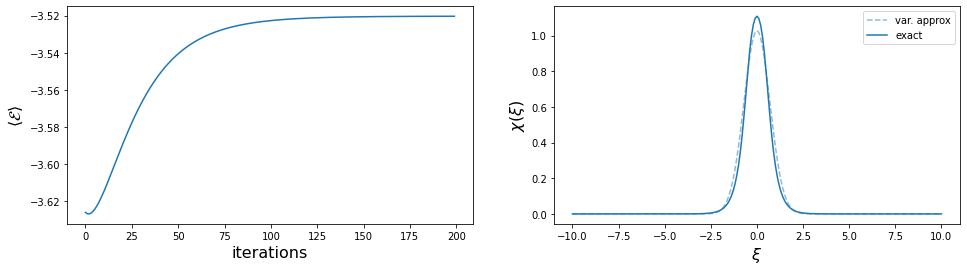

In [2]:
E_arr, xi, chi0, chi = chi_solve(Nt=2.5, n_points=201, n_iter=200, xi_min=-10, xi_max=10)
fig, axes = plt.subplots(ncols=2, figsize=(16, 4))
fopt = {"fontsize": 16}
# energy eigenvalue convergence
plt.sca(axes[0])
plt.plot(E_arr)
plt.xlabel("iterations", **fopt)
plt.ylabel(r"$\langle \mathcal{E} \rangle$", **fopt)
# soliton profile
plt.sca(axes[1])
plt.plot(xi, chi0, color="C0", linestyle="--", alpha=0.5, label="var. approx")
plt.plot(xi, chi, color="C0", label="exact")
plt.xlabel(r"$\xi$", **fopt)
plt.ylabel(r"$\chi(\xi)$", **fopt)
plt.legend()
plt.show()

Now, we want to take these stationary solitons, and collide them into each other! How do we take a stationary wave function and give it momentum? Well, we simply multiply the wave function by some spatially-dependent complex phase:

$$
\chi(\xi) \rightarrow e^{ip\xi} \chi(\xi)
$$
where $p$ is a dimensionless momentum quantity. This leaves the actual density profile $|\chi|^2$ invariant, but injects some momentum into the wave function.

In order to simulate the collison, we take our original differential equation and promote the energy eigenvalue back to a differential operator $\mathcal{E} \rightarrow i\, d/d\tau$. We can then discretize the equation using a simple CTCS (Centered-Time, Centered-Space) algorithm to evolve the wave function numerically:

$$
\chi(\xi, \tau + \delta\tau) =  \chi(\tau - \delta\tau) - 2i\, \delta\tau \left[
    -\frac{\chi(\xi+\delta\xi) - 2\chi + \chi(\xi-\delta\xi)}{2\,\delta\xi^2}
    + \beta^2 \left[\left(|\chi|^2 - 1\right)^2 - 1\right] \chi
    \right]
$$

where arguments of $\chi$ that are evaluated at $(\xi, \tau)$ have been suppressed.

In [3]:
@njit
def time_step(chi, chi_prev, Nt, dxi, dtau, tstep=2):
    chi = (
        chi_prev - (tstep*1.0j * dtau) * (
            -(np.roll(chi, -1) - 2*chi + np.roll(chi, 1))/(2*(dxi**2))
            + potential(chi, Nt)*chi
        )
    )
    # enforce boundary conditions
    chi[0] = 0
    chi[-1] = 0
    return chi

@njit
def evolve_wave_func(chi0, xi, Nt, dtau, n_iter):
    dxi = (xi[-1] - xi[0])/(len(xi) - 1)
    # evolve by a single step
    chi1 = time_step(chi0, chi0, Nt, dxi, dtau, tstep=1)
    # evolve over many iterations
    for _ in range(n_iter-1):
        chi_curr = chi1
        chi1 = time_step(chi1, chi0, Nt, dxi, dtau, tstep=2)
        chi0 = chi_curr
    return chi1

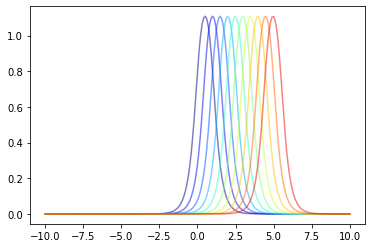

In [4]:
# single soliton moving to the right
_chi = np.copy(chi)*np.exp(0.5j*xi)
for i in range(10):
    _chi = evolve_wave_func(_chi, xi, 2.5, 1e-4, int(1e4))
    plt.plot(xi, np.abs(_chi), alpha=0.5, color=plt.cm.jet(i/10))
plt.show()

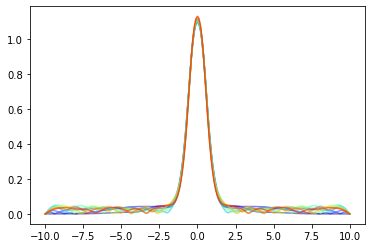

In [5]:
# single stationary soliton with variational profile.
# we can see that since it is not an exact eigenfunction, it 
# sheds some of its probability mass as the core relaxes
# to the stationary soliton profile
_chi = np.copy(chi0)*(1+0j) # (1+0j) just turns float -> complex
for i in range(10):
    _chi = evolve_wave_func(_chi, xi, 2.5, 1e-4, int(1e4))
    plt.plot(xi, np.abs(_chi), alpha=0.5, color=plt.cm.jet(i/10))
plt.show()

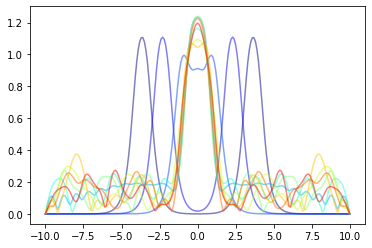

In [6]:
# two solitons with same phase colliding.
# since they are in-phase, their interaction is
# attractive, and they stick together
disp = 5.0; dxi = (xi[-1]-xi[0])/(len(xi)-1)
disp = int(round(disp/dxi))
_chi = np.roll(chi, disp)*np.exp(-0.5j*xi) + np.roll(chi, -disp)*np.exp(+0.5j*xi)
for i in range(10):
    _chi = evolve_wave_func(_chi, xi, 2.5, 1e-4, int(2.71828e4))
    plt.plot(xi, np.abs(_chi), alpha=0.5, color=plt.cm.jet(i/10))
plt.show()

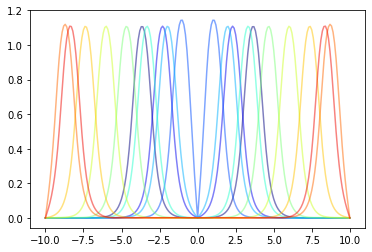

In [7]:
# two solitons with opposite phase colliding.
# because they are out of phase, their wave functions
# cannot merge easily, so they bounce off each other
disp = 5.0; dxi = (xi[-1]-xi[0])/(len(xi)-1)
disp = int(round(disp/dxi))
_chi = np.roll(chi, disp)*np.exp(-0.5j*xi) - np.roll(chi, -disp)*np.exp(+0.5j*xi)
for i in range(10):
    _chi = evolve_wave_func(_chi, xi, 2.5, 1e-4, int(2.71828e4))
    plt.plot(xi, np.abs(_chi), alpha=0.5, color=plt.cm.jet(i/10))
plt.show()